# Test running pretrained BERT on reddit data
- Maybe start adding multi level attention blocks at the end?

## Imports

In [1]:
try:
    import transformers
except ImportError as e:
    print('transformers not installed')
    print('Installing now...')
    !pip install -q git+https://github.com/huggingface/transformers.git
    pass 

In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
import transformers
import json
from tqdm.notebook import tqdm
from transformers.utils.dummy_pt_objects import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification,AutoConfig, AutoModel,AutoTokenizer,BertModel,BertConfig,AdamW, get_constant_schedule,BertForSequenceClassification,get_linear_schedule_with_warmup
import random
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Import reddit dataset, split and create PyTorch data class objects

### Dataset class

In [4]:
class Reddit(Dataset):
    def __init__(self, pd_text, pd_labels, selected_tokenizer, max_length=None):
        
       
        self.inputs = selected_tokenizer.batch_encode_plus(pd_text.tolist(), max_length = max_length,\
                                                          padding = True, truncation = True, \
                                                         add_special_tokens = True, return_tensors = "pt", \
                                                          return_attention_mask = True)
        
        self.labels = torch.Tensor(pd_labels.tolist())
        return
        
    def __len__(self): 
        return len(self.labels)
        
        
    def __getitem__(self,item):
        text = {key: self.inputs[key][item] for key in self.inputs.keys()}
        label = self.labels[item]
        return text, label

### Get datasets from .csv

In [7]:
def split_reddit_data(csv_path):
    
    #read in .csv
    data_all = None
    try:
        data_all = pd.read_csv(csv_path)
    except FileNotFoundError as e:
        print('Data csv not found')
        return
    
    data_all.dropna(subset=['comment'], inplace=True)
    
    x_train, x_testval, y_train, y_testval= train_test_split(data_all['comment'], data_all['label'], random_state=200, 
                                                                    test_size=0.2, 
                                                                    stratify=data_all['label'])
    
    x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, random_state=200, 
                                                                    test_size=0.5, 
                                                                    stratify=y_testval)
    
    return x_train, y_train, x_val, y_val, x_test, y_test 
    

In [5]:
def get_data_loaders(train, val, test, batch_size, num_workers):
    trainloader = DataLoader(train, batch_size = batch_size,num_workers=num_workers,shuffle = True)
    validationloader = DataLoader(val, batch_size = batch_size,num_workers=num_workers,shuffle = True)
    testloader = DataLoader(test, batch_size = batch_size,num_workers=num_workers,shuffle = True)
    
    return trainloader, validationloader, testloader

### Test data import

In [8]:
csv_path = 'train-balanced-sarcasm.csv'
x_train, y_train, x_val, y_val, x_test, y_test = split_reddit_data(csv_path)


(array([1.22453e+05, 1.67938e+05, 1.57328e+05, 1.51254e+05, 7.33940e+04,
        4.74850e+04, 3.84420e+04, 1.70080e+04, 1.08510e+04, 8.76200e+03,
        4.07700e+03, 2.72900e+03, 2.35800e+03, 1.06500e+03, 8.56000e+02,
        7.72000e+02, 3.74000e+02, 2.61000e+02, 3.07000e+02, 1.46000e+02,
        1.40000e+02, 1.16000e+02, 6.40000e+01, 6.10000e+01, 5.80000e+01,
        4.80000e+01, 3.10000e+01, 3.90000e+01, 2.00000e+01, 2.60000e+01]),
 array([  0.        ,   3.33333333,   6.66666667,  10.        ,
         13.33333333,  16.66666667,  20.        ,  23.33333333,
         26.66666667,  30.        ,  33.33333333,  36.66666667,
         40.        ,  43.33333333,  46.66666667,  50.        ,
         53.33333333,  56.66666667,  60.        ,  63.33333333,
         66.66666667,  70.        ,  73.33333333,  76.66666667,
         80.        ,  83.33333333,  86.66666667,  90.        ,
         93.33333333,  96.66666667, 100.        ]),
 <BarContainer object of 30 artists>)

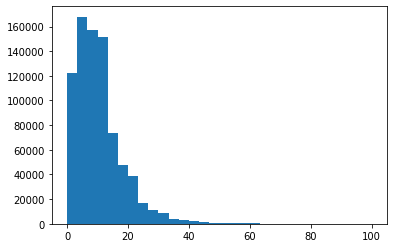

In [10]:
#word count per each sample
count = x_train.str.split().str.len()
plt.hist(count, bins=30, range=(0, 100))

Text(0.5, 1.0, 'Test Set')

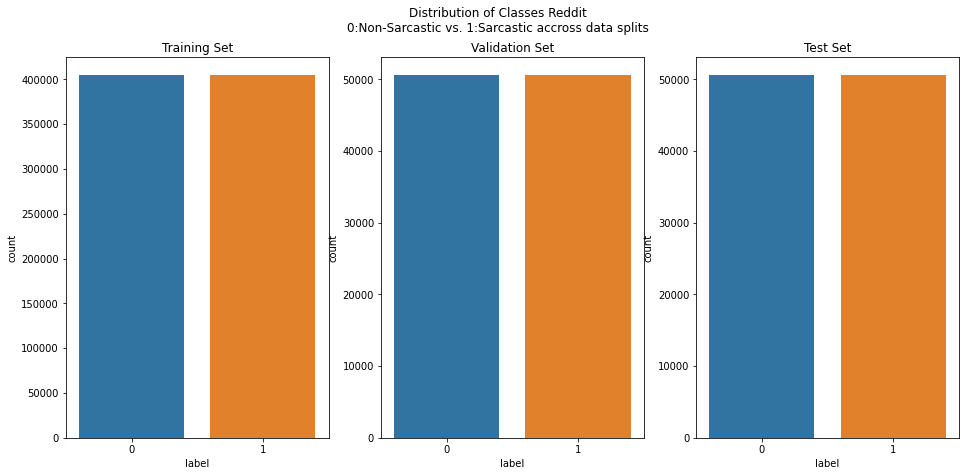

In [10]:
#check if even split between labels
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(16, 7))
fig.suptitle('Distribution of Classes Reddit\n0:Non-Sarcastic vs. 1:Sarcastic accross data splits')
sns.countplot(ax=axes[0], x=y_train)
axes[0].set_title('Training Set')
sns.countplot(ax=axes[1], x=y_val)
axes[1].set_title('Validation Set')
sns.countplot(ax=axes[2], x=y_test)
axes[2].set_title('Test Set')


### Normal Bert

In [11]:
from transformers import BertTokenizer


max_length = 35  #based on word count bar plot above, 35 is reasonable
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

reddit_train = Reddit(x_train, y_train, tokenizer, max_length)
reddit_val = Reddit(x_val, y_val, tokenizer, max_length)
reddit_test = Reddit(x_test, y_test, tokenizer, max_length)

### Large Bert

In [30]:
max_length = 35  #based on word count bar plot above, 35 is reasonable
tokenizer_large = AutoTokenizer.from_pretrained('bert-large-uncased')

reddit_train = Reddit(x_train, y_train, tokenizer_large, max_length)
reddit_val = Reddit(x_val, y_val, tokenizer_large, max_length)
reddit_test = Reddit(x_test, y_test, tokenizer_large, max_length)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [31]:
batch_size1 = 16
batch_size2 = 64
batch_size = batch_size2
num_workers = 2
trainloader, validationloader, testloader = get_data_loaders(reddit_train, reddit_val, reddit_test, batch_size, num_workers)


## Create BERT model

In [40]:
bertconfig = BertConfig()
bert = BertModel.from_pretrained("bert-base-uncased")
bert_large = BertModel.from_pretrained("bert-large-uncased")

#freeze params
for param in bert.parameters():
    param.requires_grad = False
    
for param in bert_large.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_r

In [22]:

####TODO: EXPERIMENT WITH THIS AND ADD MULTIHEAD ATTENTION AT THE END.

#like they do in tutorial: https://towardsdatascience.com/how-to-use-bert-from-the-hugging-face-transformer-library-d373a22b0209
class bert_for_sarcasm(nn.Module):
    def __init__(self,input_model):
        super(bert_for_sarcasm,self).__init__()
        
        self.input_model = input_model
        self.linear1 = nn.Linear(self.input_model.config.hidden_size, 256)
        self.linear2 = nn.Linear(256,128)
        self.out = nn.Linear(128,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        self.log = nn.LogSoftmax(dim = 1)
        
    def forward(self, input_values, attention_mask):
        _,output = self.input_model(input_values, attention_mask=attention_mask).values()
        output = self.dropout(self.relu(self.linear1(output)))
        output = self.dropout(self.relu(self.linear2(output)))
        #out = self.sigmoid(self.out(output))
        output = self.log(self.out(output))
        return output

'\nclass bert_for_sarcasm(nn.Module):\n\n    def __init__(self,input_model):\n        super(bert_for_sarcasm,self).__init__()\n        \n        self.input_model = input_model\n        \n        self.linear = nn.Linear(768,256)\n        \n        self.linear2 = nn.Linear(256,128)\n        \n        self.linear3 = nn.Linear(128,2)\n        \n        self.relu = nn.ReLU()\n        \n        self.log = nn.LogSoftmax(dim = 1)\n    \n    def forward(self, encoding):\n        \n        _,output = self.input_model(**encoding)\n\n        output = self.linear(output)\n        \n        output = self.relu(output)\n        \n        output = self.linear2(output)\n        \n        output = self.relu(output)\n        \n        output = self.linear3(output)\n        \n        output = self.log(output)\n        \n        return output\n    '

In [41]:
class bert_large_for_sarcasm(nn.Module):
    def __init__(self,input_model):
        super(bert_large_for_sarcasm,self).__init__()
        
        self.input_model = input_model
        self.out = nn.Linear(self.input_model.config.hidden_size, 2)
        self.log = nn.LogSoftmax(dim = 1)
        
    def forward(self, input_values, attention_mask):
        _,output = self.input_model(input_values, attention_mask=attention_mask).values()
        output = self.log(self.out(output))
        return output

In [42]:
#sarcasm_model = bert_for_sarcasm(bert)
sarcasm_model = bert_large_for_sarcasm(bert_large)
sarcasm_model.to(device)

bert_large_for_sarcasm(
  (input_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [43]:
print(sum(p.numel() for p in sarcasm_model.parameters() if p.requires_grad))
print(sum(p.numel() for p in sarcasm_model.parameters()))

2050
335143938


## Training

In [44]:
import time
import datetime
import math

#Training sarcasm bert
Epochs = 4

#optimizer, loss function and scheduler for learning rate
#optimizer = torch.optim.AdamW(sarcasm_model.parameters(),lr = 1e-3,eps = 1e-6)
lr1 = 1e-3
lr2 = 3e-4
lr3 = 2e-5
optimizer = torch.optim.AdamW(sarcasm_model.parameters(),lr = lr3)
loss_function = nn.NLLLoss()
#loss_function = nn.BCELoss()
#loss_function = nn.BCEWithLogitsLoss()
# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = len(trainloader)*Epochs)

loss_acc = 0 
losses = []

start_time = time.time()
num_iters = math.ceil(len(reddit_train)/ batch_size)

for epoch in range(1, Epochs+1):
    
    print('Epoch: ',epoch)
    train_iter = iter(trainloader)
    sarcasm_model.train()
    train_correct = 0
    train_total = 0
    for idx, (encodings, labels) in enumerate(train_iter):

        labels = labels.type(torch.LongTensor).to(device)
        #labels = labels.to(device)
       
        #encodings = {k:v.type(torch.long).to(device) for k,v in encodings.items()}
        inputs = encodings['input_ids']
        attention_mask = encodings['attention_mask']
        inputs,attention_mask = inputs.to(device), attention_mask.to(device)
        
        #sarcasm_model.zero_grad()
        optimizer.zero_grad()

        #output = sarcasm_model(encodings)
        output = sarcasm_model(inputs, attention_mask)
        
        
        #out = output.argmax(axis = -1).type(torch.FloatTensor).to(device)
        #out.requires_grad = True
        
        loss = loss_function(output,labels)
        losses.append(loss)

        loss.backward()
        
        optimizer.step()
        
        train_correct += (output.argmax(axis = -1) == labels).float().sum().item()
        train_total += len(labels)
        loss_acc +=loss.item()
        
        if idx%2000 == 0:
            et = time.time() - start_time
            et = str(datetime.timedelta(seconds=et))[:-7]
            log = "Elapsed [{}], Iteration [{}/{}]".format(et, idx+1, num_iters)
            log += "Loss: {:.4f}".format(loss)
            print(log)
            
    # at the end of each epoch, calculate validation loss + accuracy and display train accuracy vs val accurac   
    valid_loss = 0.0
    sarcasm_model.eval()
    val_correct = 0
    val_total = 0
    print("Calculating validation accuracy....")
    for encodings, labels in validationloader:
        inputs = encodings['input_ids']
        attention_mask = encodings['attention_mask']
        if torch.cuda.is_available():
            labels = labels.type(torch.LongTensor).to(device)
            #encodings = {k:v.type(torch.long).to(device) for k,v in encodings.items()}
            #labels = labels.to(device)
            inputs, attention_mask = inputs.to(device), attention_mask.to(device)
            
        preds = sarcasm_model(inputs,attention_mask)
        #preds = preds.argmax(axis = -1).type(torch.FloatTensor).to(device)
        loss = loss_function(preds,labels)
        val_correct += (preds.argmax(axis = -1) == labels).float().sum().item()
        val_total += len(labels)
        
    training_acc = round(train_correct/train_total,2)
    validation_acc = round(val_correct/val_total,2)
    print("Epoch {}. Training accuracy: {}. Validation accuracy: {}.".format(epoch, training_acc, validation_acc)) 

Epoch:  1
Elapsed [0:00:06], Iteration [1/12635]Loss: 0.7578
Elapsed [0:04:29], Iteration [2001/12635]Loss: 0.6866
Elapsed [0:08:53], Iteration [4001/12635]Loss: 0.6694
Elapsed [0:13:16], Iteration [6001/12635]Loss: 0.6518
Elapsed [0:17:39], Iteration [8001/12635]Loss: 0.6710
Elapsed [0:22:02], Iteration [10001/12635]Loss: 0.6800
Elapsed [0:26:26], Iteration [12001/12635]Loss: 0.6386
Calculating validation accuracy....
Epoch 1. Training accuracy: 0.58. Validation accuracy: 0.61.
Epoch:  2
Elapsed [0:31:16], Iteration [1/12635]Loss: 0.6685
Elapsed [0:35:39], Iteration [2001/12635]Loss: 0.6803
Elapsed [0:40:02], Iteration [4001/12635]Loss: 0.6428
Elapsed [0:44:24], Iteration [6001/12635]Loss: 0.6344
Elapsed [0:48:47], Iteration [8001/12635]Loss: 0.6352
Elapsed [0:53:10], Iteration [10001/12635]Loss: 0.6712
Elapsed [0:57:33], Iteration [12001/12635]Loss: 0.6903
Calculating validation accuracy....
Epoch 2. Training accuracy: 0.61. Validation accuracy: 0.62.
Epoch:  3
Elapsed [1:02:22], Ite

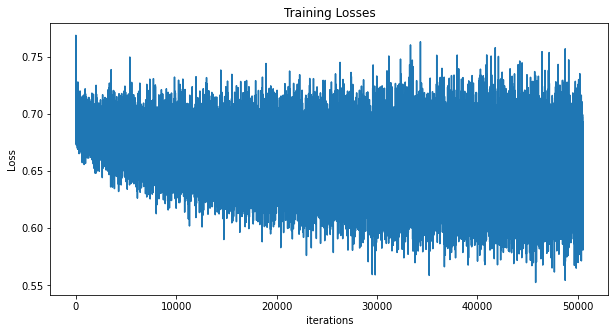

In [45]:
# Losses
plt.figure(figsize=(10,5))
plt.title("Training Losses")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

## Testing

In [46]:
correct = []
final_pred = []
final_lab = []
with torch.no_grad():
    
    for encodings, labels in testloader:
        inputs = encodings['input_ids']
        attention_mask = encodings['attention_mask']
        inputs, attention_mask = inputs.to(device), attention_mask.to(device)
        output = sarcasm_model(inputs,attention_mask).cpu()
        preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()
        l = labels.cpu().numpy()
        comp = l == preds
        final_lab.extend(l)
        final_pred.extend(preds)
        for i in range(l.size):
            if comp[i] == True:
                correct.append(1)
            else:
                correct.append(0)

### Stats

In [47]:
r_words = ["Sarcastic","Not Sarcastic"]
class_report = classification_report(final_lab,final_pred,target_names =r_words)
print('\033[1m'+'Precision, Recall and Accuracy for Reddit Data:\n')
print(class_report)

Precision, Recall and Accuracy for Reddit Data:

               precision    recall  f1-score   support

    Sarcastic       0.61      0.70      0.65     50540
Not Sarcastic       0.65      0.55      0.60     50537

     accuracy                           0.63    101077
    macro avg       0.63      0.63      0.63    101077
 weighted avg       0.63      0.63      0.63    101077



### Examples?